# Defanging a lion

## Problem statement

In your safari trip, you came across a dangerous lion.

In [1]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/francesco-ZxNKxnR32Ng-unsplash.jpg -o lion.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 98231  100 98231    0     0   581k      0 --:--:-- --:--:-- --:--:--  588k


In [2]:
from PIL import Image

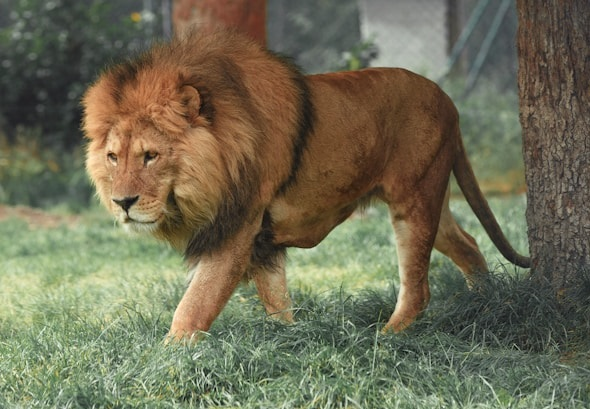

In [3]:
im = Image.open("lion.jpg").convert("RGB")
im

Ensure your safety by transforming the lion in this picture into a slightly less dangerous animal: an african buffalo.

Here is how your work will be scored:

- 1 pt awarded for demonstrating that your transformed lion is closer in meaning to the text "a peaceful african buffalo" than the text "a prowling lion on the hunt" by `openai/clip-vit-base-patch32`

> For CLIP scoring, use cosine similarity for your calculation. Scoring less than 0.5 using the reference implementation of binary softmax is sufficient to be considered as closer to buffalo. To ensure that your implementation is correct, and to save you the headache of losing progress due to not realizing you need to normalize your vectors, sample code is provided below as a reference. I am not mandating you use this code because you might prefer to handle the vectors directly instead of being wrapped in transformers as a dictionary with key "pixel_values"

- 1 pt awarded if the point above is earned, and your transformed lion has less than 0.3 SSIM loss compared to the original lion.

> For SSIM loss, install `kornia` and look at the sample code provided below.

- 1 pt awarded if `openai/clip-vit-base-patch32` considers the softmaxed probability that your transformed lion is a buffalo is higher than 0.7 (i.e. lion < 0.3) AND SSIM loss is less than 0.3
- 2 pts awarded for demonstrating that your transformed lion is so convincingly transformed into a buffalo, that it visually looks more like a buffalo than a lion. SSIM loss criterion not applicable for these points.
    - If it clearly looks like a buffalo to me, these pts will count. If not, I will load any readily-available image classification model pretrained on ImageNet and check if the transformed image is closer to class 291 (lion) or class 346 (water buffalo). The reason for this evaluation is to make sure that you aren't creating an adversarial image that is barely modified but scores the correct class.
    - Make sure that your image is shown in your notebook for further inspection.
- 1 pt awarded for explaining your thought process and reasoning for your work done. Keep it brief, one short paragraph is enough!

Partial credit will be granted at discretion.

You are allowed to use:

- any pretrained model from `torchvision` and `transformers`
- any code and pretrained models made available to you as part of this problem
- standard ML libraries (e.g. numpy, sklearn, albumentations, einops)
- additional images of your own

You are prohibited to use:

- pretrained models that are not from the allowed sources. Off the shelf models, dedicated libraries and github repos are not allowed.
- responses from LLM APIs like OpenAI and using the response as your solution
- hosted local LLMs to generate images and use the generated image as your solution
- any technique that amounts to replacing the lion with a different picture

You might find this mysterious SomeNetwork useful.

Requirements: 
- Install `attrs`. You should already have `numpy`, `torch`, and `torchvision`
- Download `somenetwork.py` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/somenetwork.py
- Download weights (370+ MB combined):
    - `encoder.pt` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/encoder.pt
    - `decoder.pt` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/decoder.pt
- Download `using-somenetwork.ipynb` from https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/defanging_lion/using-somenetwork.ipynb to see how to use it

## Sample code to help you get started

```python
device = "cuda" if torch.cuda.is_available() else "cpu"

from PIL import Image
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

text_inputs = processor(
    text="a peaceful african buffalo", return_tensors="pt", padding=True
).to(device)
buffalo_text_embeddings = model.get_text_features(**text_inputs).float()
buffalo_text_embeddings = F.normalize(buffalo_text_embeddings, p=2, dim=-1)

text_inputs = processor(text="a prowling lion on the hunt", return_tensors="pt", padding=True).to(
    device
)
lion_text_embeddings = model.get_text_features(**text_inputs).float()
lion_text_embeddings = F.normalize(lion_text_embeddings, p=2, dim=-1)

image = Image.open("lion.jpg").convert("RGB")
inputs = processor(
    images=image,
    return_tensors="pt",
    padding=True,
    do_rescale=True,
    do_normalize=True,
)
inputs = {k: v.to(device) for k, v in inputs.items()}

def compute_clip_lion2buffalo_loss(image_inputs):
    image_embeddings = model.get_image_features(**image_inputs).float()
    image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)

    global lion_text_embeddings
    global buffalo_text_embeddings

    # Cosine similarity (higher = more similar)
    lion_sim = (image_embeddings @ lion_text_embeddings.T).squeeze()
    buffalo_sim = (image_embeddings @ buffalo_text_embeddings.T).squeeze()

    scores = torch.stack([lion_sim, buffalo_sim])
    probs = torch.softmax(scores, dim=0)
    lion_score = probs[0]
    
    # <0.5 means closer to buffalo
    return lion_score
```

```python
from kornia.losses import SSIMLoss

ssim_loss_fxn = SSIMLoss(window_size=7).to(device)

a = torch.rand(1, 3, 256, 256)
b = torch.rand(1, 3, 256, 256)

ssim_loss_fxn(a, b)
```

## Your work below

In [4]:
# Read everything clearly before you start!
import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPProcessor
from kornia.losses import SSIMLoss

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
def to_text_embedding(text):
    clip_inputs = processor(
        text=text, 
        return_tensors="pt", 
        padding=True
    ).to(device)
    text_embs = model.get_text_features(**clip_inputs).float()
    text_embs = F.normalize(text_embs, p=2, dim=-1)
    return text_embs

In [7]:
buffalo_text = "a peaceful african buffalo"
buffalo_emb = to_text_embedding(buffalo_text).detach()

lion_text = "a prowling lion on the hunt"
lion_emb = to_text_embedding(lion_text).detach()

In [8]:
def clip_preprocess(image, do_rescale=True):
    inputs = processor(
        images=image,
        return_tensors="pt",
        padding=True,
        do_rescale=do_rescale,
        do_normalize=True
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs

In [9]:
def compute_clip_lion2buffalo_loss(clip_inputs):
    embs = model.get_image_features(**clip_inputs).float()
    embs = F.normalize(embs, p=2, dim=-1)

    global buffalo_emb, lion_emb
    # Cosine similarity (higher = more similar)
    lion_sim = (embs @ lion_emb.T).squeeze()
    buffalo_sim = (embs @ buffalo_emb.T).squeeze()

    scores = torch.stack([lion_sim, buffalo_sim])
    probs = torch.softmax(scores, dim=0)
    lion_score = probs[0]
    
    # <0.5 means closer to buffalo
    return lion_score

In [10]:
def compute_ssim_loss(tensor1, tensor2):  # Each tensor is an image with shape [C, H, W]
    ssim_loss_fxn = SSIMLoss(window_size=7).to(device)
    return ssim_loss_fxn(tensor1.unsqueeze(0), tensor2.unsqueeze(0))

---

In [11]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from somenetwork import Encoder, Decoder, map_pixels, unmap_pixels

In [12]:
enc = Encoder().to(device)
with open("encoder.pt", "rb") as f:
    enc.load_state_dict(torch.load(f, map_location=device))

dec = Decoder().to(device)
with open("decoder.pt", "rb") as f:
    dec.load_state_dict(torch.load(f, map_location=device))

In [13]:
def resize_and_crop(image, target_image_size=224):
    s = min(image.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * image.size[1]), round(r * image.size[0]))
    
    image = TF.resize(image, s, interpolation=Image.LANCZOS)
    image = TF.center_crop(image, output_size=2 * [target_image_size])
    return image

In [14]:
def vae_preprocess(image):
    image = resize_and_crop(image)
    image = torch.unsqueeze(T.ToTensor()(image), 0)
    return map_pixels(image)

In [15]:
def get_enc_latent(image):
    x = vae_preprocess(image).to(device)
    z_logits = enc(x)
    return z_logits

In [16]:
def generate_image(z):
    x_stats = dec(z).float()
    x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))[0]
    return x_rec

In [17]:
def default_transform(z_logits):  # Given in using-somenetwork.ipynb
    z = torch.argmax(z_logits, dim=1)
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    return z

def morph(image, transform=default_transform):
    z_logits = get_enc_latent(image)
    z = transform(z_logits)
    return generate_image(z)

In [18]:
image2tensor = T.ToTensor()  # This is a function
tensor2image = T.ToPILImage(mode="RGB")  # This is a function

## Demo

This section makes sure everything works fine.

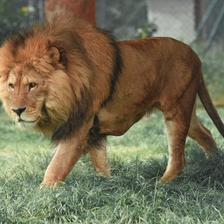

In [19]:
im_orig = resize_and_crop(im)  # Will use this instead of the above
im_tensor_orig = image2tensor(im_orig).to(device)
im_orig

In [20]:
compute_clip_lion2buffalo_loss(clip_preprocess(im_orig)).item()

0.5242251753807068

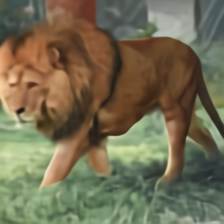

In [21]:
im_rec1 = tensor2image(morph(im_orig))
im_rec1

In [22]:
compute_clip_lion2buffalo_loss(clip_preprocess(im_rec1)).item()

0.5213652849197388

In [23]:
compute_ssim_loss(im_tensor_orig, image2tensor(im_rec1).to(device)).item()

0.1635081022977829

## Main

In [24]:
import os
import heapq
import torch.optim as optim
from uuid import uuid4
from torchvision.models import resnet18, ResNet18_Weights
from IPython.display import display

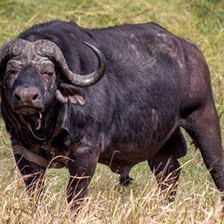

In [25]:
im_buff = Image.open("my_buffalo.jpeg").convert("RGB")  # Get this from the Internet
im_buff = resize_and_crop(im_buff)
im_buff_tensor = image2tensor(im_buff).to(device)
im_buff

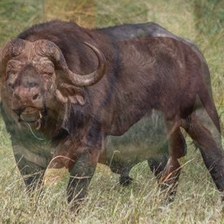

In [26]:
Image.blend(im_orig, im_buff, 0.6)

Align the two animals carefully to achieve the best training outcome!

In [27]:
compute_clip_lion2buffalo_loss(clip_preprocess(im_buff)).item()

0.47733670473098755

In [28]:
z_buff = torch.argmax(get_enc_latent(im_buff), dim=1)
z_buff_one_hot = F.one_hot(z_buff, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
z_buff.shape, z_buff_one_hot.shape

(torch.Size([1, 28, 28]), torch.Size([1, 8192, 28, 28]))

In [29]:
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
for p in resnet.parameters():
    p.requires_grad_(False)
resnet = torch.nn.Sequential(*list(resnet.children())[:5]).to(device)  # up to layer2
resnet.eval();

In [30]:
def compute_perceptual_loss(x_gen, x_target):
    return F.mse_loss(resnet(x_gen.unsqueeze(0)), resnet(x_target.unsqueeze(0)))

In [31]:
def hard_binary(x):
    hard = (x >= 0.5).float()
    return (hard - x).detach() + x

def hard_binary_flipped(x):
    hard = (x < 0.5).float()
    return (hard - x).detach() + x

In [32]:
class TopK:
    def __init__(self, k):
        self.k = k
        self.heap = []  # min-heap of (score, item)

    def add(self, score, item):
        if len(self.heap) < self.k:
            heapq.heappush(self.heap, (score, item))
        else:
            # only add if the new score is better than the smallest in heap
            if score > self.heap[0][0]:
                heapq.heappushpop(self.heap, (score, item))

    def get_top_k(self):
        return sorted(self.heap, key=lambda x: -x[0])  # (score, item), sorted by score desc

In [33]:
best_40 = TopK(40)

In [34]:
def my_transform(z_logits, num_epochs=2000):
    z = torch.argmax(z_logits, dim=1)
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    z.requires_grad_(False)

    keep_mask = torch.randn(z_buff.shape).unsqueeze(1).to(device)
    keep_mask.requires_grad_(True)

    optimizer = optim.Adam([keep_mask], lr=0.8)
    for epoch in range(num_epochs):
        z_edited = hard_binary(keep_mask) * z + hard_binary_flipped(keep_mask) * z_buff_one_hot
        x_rec = generate_image(z_edited)

        perceptual_loss = compute_perceptual_loss(x_rec, im_buff_tensor)
        ssim_loss = compute_ssim_loss(im_tensor_orig, x_rec)
        total_loss = perceptual_loss + ssim_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        best_40.add(-total_loss, x_rec)

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                num_changed = hard_binary_flipped(keep_mask).sum().int()
                print(f"Epoch {epoch + 1}: perceptual loss - {perceptual_loss.item()}, SSIM loss - {ssim_loss.item()}, total loss - {total_loss.item()}, changed - {num_changed.item()}")

    return z_edited

Epoch 1: perceptual loss - 0.09035814553499222, SSIM loss - 0.3489692211151123, total loss - 0.4393273591995239, changed - 491
Epoch 101: perceptual loss - 0.10824716836214066, SSIM loss - 0.28423038125038147, total loss - 0.39247754216194153, changed - 310
Epoch 201: perceptual loss - 0.11203063279390335, SSIM loss - 0.28258222341537476, total loss - 0.3946128487586975, changed - 315
Epoch 301: perceptual loss - 0.11377266049385071, SSIM loss - 0.2804279923439026, total loss - 0.3942006528377533, changed - 302
Epoch 401: perceptual loss - 0.11150404810905457, SSIM loss - 0.2826197147369385, total loss - 0.39412376284599304, changed - 309
Epoch 501: perceptual loss - 0.11150287836790085, SSIM loss - 0.2827511727809906, total loss - 0.39425405859947205, changed - 311
Epoch 601: perceptual loss - 0.11074018478393555, SSIM loss - 0.2860584259033203, total loss - 0.39679861068725586, changed - 308
Epoch 701: perceptual loss - 0.11149676889181137, SSIM loss - 0.28297704458236694, total loss

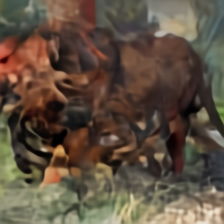

In [35]:
im_rec2 = tensor2image(morph(im_orig, my_transform))
im_rec2

In [36]:
output_folder_dir = f"./my_output_{str(uuid4()).split("-")[0]}"
os.makedirs(output_folder_dir, exist_ok=True)

Idx 2: clip_loss=0.4998159408569336, ssim_loss=0.27797865867614746


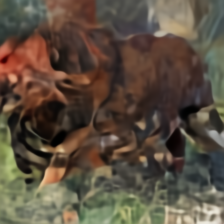

Idx 7: clip_loss=0.49839234352111816, ssim_loss=0.2799650728702545


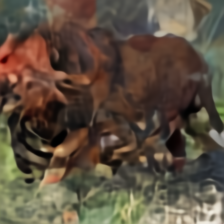

Idx 9: clip_loss=0.49890968203544617, ssim_loss=0.27885955572128296


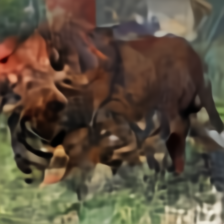

Idx 12: clip_loss=0.49776408076286316, ssim_loss=0.28016239404678345


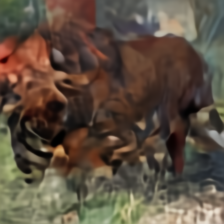

Idx 13: clip_loss=0.49539488554000854, ssim_loss=0.27987438440322876


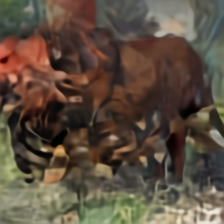

Idx 14: clip_loss=0.4948800802230835, ssim_loss=0.27926501631736755


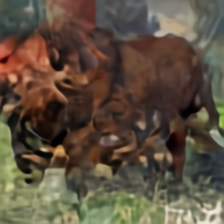

Idx 16: clip_loss=0.49648094177246094, ssim_loss=0.281894326210022


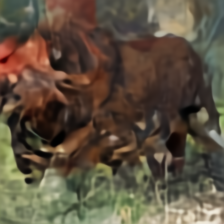

Idx 22: clip_loss=0.4952239692211151, ssim_loss=0.2803843915462494


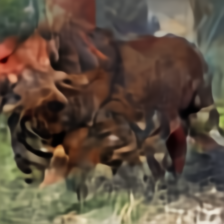

Idx 24: clip_loss=0.49202126264572144, ssim_loss=0.27914464473724365


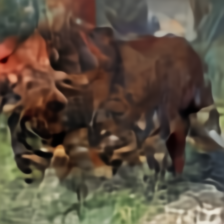

Idx 25: clip_loss=0.4945698082447052, ssim_loss=0.27835217118263245


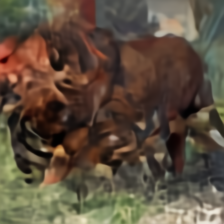

Idx 26: clip_loss=0.4955630600452423, ssim_loss=0.2793712615966797


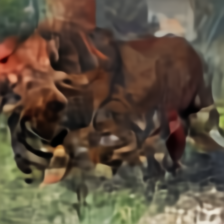

Idx 28: clip_loss=0.4943154752254486, ssim_loss=0.2795189619064331


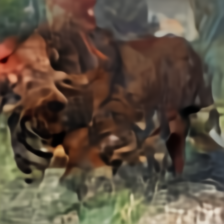

Idx 30: clip_loss=0.49675121903419495, ssim_loss=0.27790141105651855


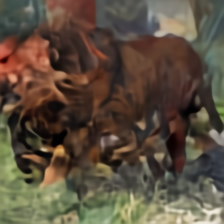

Idx 34: clip_loss=0.4972626864910126, ssim_loss=0.27736738324165344


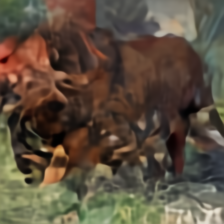

Idx 36: clip_loss=0.49915674328804016, ssim_loss=0.2796093225479126


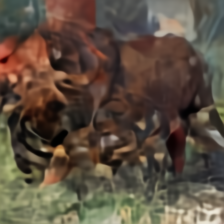

Idx 37: clip_loss=0.4980992078781128, ssim_loss=0.28026053309440613


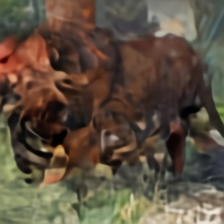

In [37]:
for idx, (_, tensor_rec_test) in enumerate(best_40.get_top_k()):
    im_rec_test = tensor2image(tensor_rec_test)

    clip_loss = compute_clip_lion2buffalo_loss(clip_preprocess(im_rec_test)).item()
    ssim_loss = compute_ssim_loss(image2tensor(im_orig).to(device), tensor_rec_test).item()
    if clip_loss < 0.5 and ssim_loss < 0.3:
        print(f"Idx {idx}: {clip_loss=}, {ssim_loss=}")
        im_rec_test.save(f"./{output_folder_dir}/{idx}.jpeg")
        display(im_rec_test)

## Explanation

We implemented a latent space mixing approach to transform a lion image into a buffalo. Through gradient-based optimization, we learned a binary mask that selectively replaces parts of the lion's latent code with corresponding regions from the buffalo's latent code. The optimization objective combines perceptual loss (using ResNet features) and SSIM loss to maintain visual quality while encouraging buffalo-like characteristics.